In [93]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime
from utils.mvo_strategy import MVOStrategy, NaiveStrategy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### dataload

In [94]:
# sector_tickers = [
#     "XLF",  # Financials
#     "XLK",  # Technology
#     "XLV",  # Health Care
#     "XLY",  # Consumer Discretionary
#     "XLP",  # Consumer Staples
#     "XLE",  # Energy
#     "XLI",  # Industrials
#     "XLU",  # Utilities
#     "XLB",  # Materials
#     "XLRE",  # Real Estate
#     "XLC",  # Communication Services
# ]

# import data from csv
df_ret = pd.read_parquet("../data/snp_old/returns_1mo.parquet")
df_prices = pd.read_parquet("../data/snp_old/prices_1mo.parquet")
df_spy = pd.read_parquet("../data/snp_old/prices_sp500_1mo.parquet")

# df_ret = pd.read_parquet("../data/snp_new/returns_1d.parquet")
# df_prices = pd.read_parquet("../data/snp_new/prices_1d.parquet")
# df_spy = pd.read_parquet("../data/snp_new/prices_sp500_1d.parquet")

# ALTERNATIVE DATASET
# df_ret = pd.read_parquet("../data/returns_intl_indices.parquet")
# df_prices = pd.read_parquet("../data/prices_intl_indices.parquet")
# df_msci = pd.read_parquet("../data/prices_msci.parquet")

sector_tickers = df_ret.columns.tolist()
print(sector_tickers)

['XLF', 'XLK', 'XLV', 'XLY', 'XLP', 'XLE', 'XLI', 'XLU', 'XLB']


### params & modelrun

In [95]:
# Test different lookback periods
# lookback_periods = [
#     10,
#     30,
#     60,
#     90,
#     120,
#     150,
#     252,
#     252 * 2,
#     252 * 3,
# ] # days

lookback_periods = [12, 24, 36, 60, 72, 120, 144]  # months

# full date range from paper
START_DATE = "2012-01-01"
END_DATE = "2022-12-31"

# yr = 2011
# START_DATE = f"{yr}-01-01"
# END_DATE = f"{yr}-12-31"

In [96]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
# also add start and end date to the name
results_dir = f"../results/{timestamp}_mvo_backtest_[{START_DATE},{END_DATE}]/"
os.makedirs(results_dir, exist_ok=True)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# MVO strategy

all_history = []
all_metrics = []

for lookback in lookback_periods:
    print(f"Running MVO with lookback period: {lookback}")
    optimizer = MVOStrategy(tickers=sector_tickers, lookback=lookback)
    portfolio = optimizer.backtest(
        df_ret, df_prices, start_date=START_DATE, end_date=END_DATE, method="scipy"
    )
    # method ( lookback = 60 )
    # scipy = 23 sec -> FASTEST
    # pypfopt = 35 sec
    # skfolio = 22 sec

    portfolio_df = pd.DataFrame(portfolio.get_history())
    portfolio_df["lookback"] = lookback

    portfolio_metrics = portfolio.calc_metrics()
    portfolio_metrics["lookback"] = lookback

    all_history.append(portfolio_df)
    all_metrics.append(portfolio_metrics)

# Combine all results
history_df = pd.concat(all_history, axis=0)
metrics_df = pd.DataFrame(all_metrics)

history_df.to_parquet(f"{results_dir}/mvo_history.parquet")
metrics_df.to_csv(f"{results_dir}/mvo_metrics.csv")

Running MVO with lookback period: 12


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 4071.18it/s]


Running MVO with lookback period: 24


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3813.81it/s]


Running MVO with lookback period: 36


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3866.26it/s]


Running MVO with lookback period: 60


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3526.38it/s]


Running MVO with lookback period: 72


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3440.15it/s]


Running MVO with lookback period: 120


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3327.31it/s]


Running MVO with lookback period: 144


Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 3188.94it/s]


In [97]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# Naive strategy ( no need for lookback )

optimizer = NaiveStrategy(tickers=sector_tickers)
portfolio = optimizer.backtest(
    df_ret, df_prices, start_date=START_DATE, end_date=END_DATE
)

naive_portfolio_df = pd.DataFrame(portfolio.get_history())
naive_portfolio_metrics = pd.DataFrame(portfolio.calc_metrics(), index=[0])

naive_portfolio_df.to_parquet(f"{results_dir}/naive_history.parquet")
naive_portfolio_metrics.to_csv(f"{results_dir}/naive_metrics.csv")

Running backtest: 100%|██████████| 2870/2870 [00:00<00:00, 18059.50it/s]


### plot

In [98]:
# # Load df from previous run
# results_dir = "../results/20250602_010152_mvo_backtest"
# history_df = pd.read_parquet(f"{results_dir}/mvo_history.parquet")
# metrics_df = pd.read_csv(f"{results_dir}/mvo_metrics.csv")

In [99]:
# compare with portfolio value development if i just buy and hold SPY
ref_df = df_spy
ref_ticker = "^GSPC"

initial_balance = 100_000
shares_spy = initial_balance / ref_df[ref_ticker].loc[ref_df.index > START_DATE].iat[0]

spy_lastdate = ref_df[ref_ticker].loc[ref_df.index < END_DATE].index.max()
spy_lastval = (ref_df.loc[spy_lastdate] * shares_spy).values[0]
print(f"{ref_ticker} final value: {spy_lastval:.2f}")

# compare if MVO with lookback outperforms SnP500
# simple comparison with True False in new column
df = (
    history_df.groupby("lookback")[["portfolio_value"]]
    .last()
    .sort_values(by="portfolio_value", ascending=False)
)
df["outperforms_spy"] = df["portfolio_value"] > spy_lastval
df

^GSPC final value: 281141.98


,portfolio_value,outperforms_spy
lookback,,
12,409963.906697,True
36,381435.960085,True
60,371129.347395,True
72,355463.518612,True
24,351425.975819,True
144,305800.320665,True
120,290999.200974,True


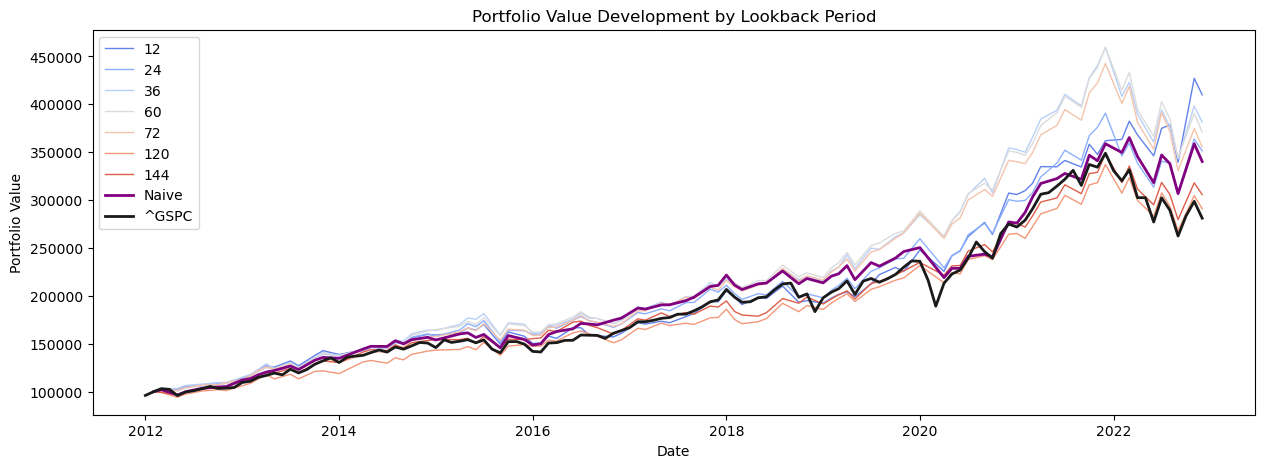

In [100]:
# reset sns style
sns.reset_defaults()

# PLOT Portfolio Value Development
plt.figure(figsize=(15, 5))
palette = sns.color_palette(
    "coolwarm", as_cmap=False, n_colors=history_df["lookback"].nunique()
)
sns.lineplot(
    data=history_df,
    x="date",
    y="portfolio_value",
    hue="lookback",
    palette=palette,
    lw=1,
)

# plot naive strategy
sns.lineplot(
    data = naive_portfolio_df,
    x = "date",
    y = "portfolio_value",
    c="purple",
    label="Naive",
    lw=2,
)

# plot direct investment in SPY
plt.plot(
    ref_df[ref_ticker].loc[START_DATE:END_DATE] * shares_spy,
    c="k",
    label=ref_ticker,
    lw=2,
)

plt.title("Portfolio Value Development by Lookback Period")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
# save plot
plt.savefig(f"{results_dir}/portfolio_value_development.pdf", dpi=300)
plt.show()

In [101]:
# Filter relevant lookback
lookback = 60
focus_df = history_df[history_df["lookback"] == lookback]

# === Monthly returns ===
month_df = focus_df[["portfolio_value"]].resample("ME").last()
month_df = pd.concat(
    [
        pd.DataFrame(
            {"portfolio_value": [initial_balance]},
            index=[month_df.index.min() - pd.DateOffset(months=1)],
        ),
        month_df,
    ]
)
month_df["monthly_ret"] = month_df["portfolio_value"].pct_change() * 100
month_df = month_df.iloc[1:]
month_df["year"] = month_df.index.year
month_df["month"] = month_df.index.month
monthly_pivot = month_df.pivot(index="year", columns="month", values="monthly_ret")
monthly_pivot = monthly_pivot.sort_index(
    ascending=True
)  # TODO implemented: ascending years

monthly_rets = month_df["monthly_ret"].values

# === Annual returns ===
annual_df = focus_df[["portfolio_value"]].resample("YE").last()
annual_df = pd.concat(
    [
        pd.DataFrame(
            {"portfolio_value": [initial_balance]},
            index=[annual_df.index.min() - pd.DateOffset(years=1)],
        ),
        annual_df,
    ]
)
annual_df["annual_ret"] = annual_df["portfolio_value"].pct_change() * 100
annual_df = annual_df.iloc[1:]
annual_df["year"] = annual_df.index.year
annual_df = annual_df.sort_values(by="year")  # TODO implemented: ascending years
annual_mean = annual_df["annual_ret"].mean()

# === PLOT with square plots and updated formatting ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_theme()

# 1. Monthly heatmap
sns.heatmap(
    monthly_pivot,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    ax=axes[0],
    cbar=False,
    linewidths=0.2,
    linecolor="white",
)
axes[0].set_title("Monthly returns (%)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Year")
axes[0].set_aspect("equal")

# 2. Annual returns bar chart (scaled to %)
axes[1].barh(annual_df["year"], annual_df["annual_ret"], color="cornflowerblue")
axes[1].axvline(x=annual_mean, color="dodgerblue", linestyle="--", lw=3, label="Mean")
axes[1].set_title("Annual returns")
axes[1].set_yticks(annual_df["year"])

# 3. Monthly return distribution
axes[2].hist(monthly_rets, bins=20, color="#ff5812", edgecolor="white")
axes[2].axvline(x=monthly_rets.mean(), color="gold", linestyle="--", lw=3, label="Mean")
axes[2].set_title("Distribution of monthly returns")
axes[2].set_ylabel("Number of months")

# Formatting for bar charts and hist
for idx in [1, 2]:
    axes[idx].axvline(x=0, color="black", lw=2)
    axes[idx].set_xlabel("Returns (%)")
    axes[idx].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axes[idx].legend()

# Super title and layout
plt.suptitle(f"Returns for lookback = {lookback}")
plt.tight_layout()
plt.savefig(f"{results_dir}/paper_figure4_returns_{lookback}.pdf", dpi=300)

/var/folders/4n/p4zjp9g17rx7p18klqb5zmvc0000gn/T/ipykernel_92152/213382042.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  month_df["monthly_ret"] = month_df["portfolio_value"].pct_change() * 100


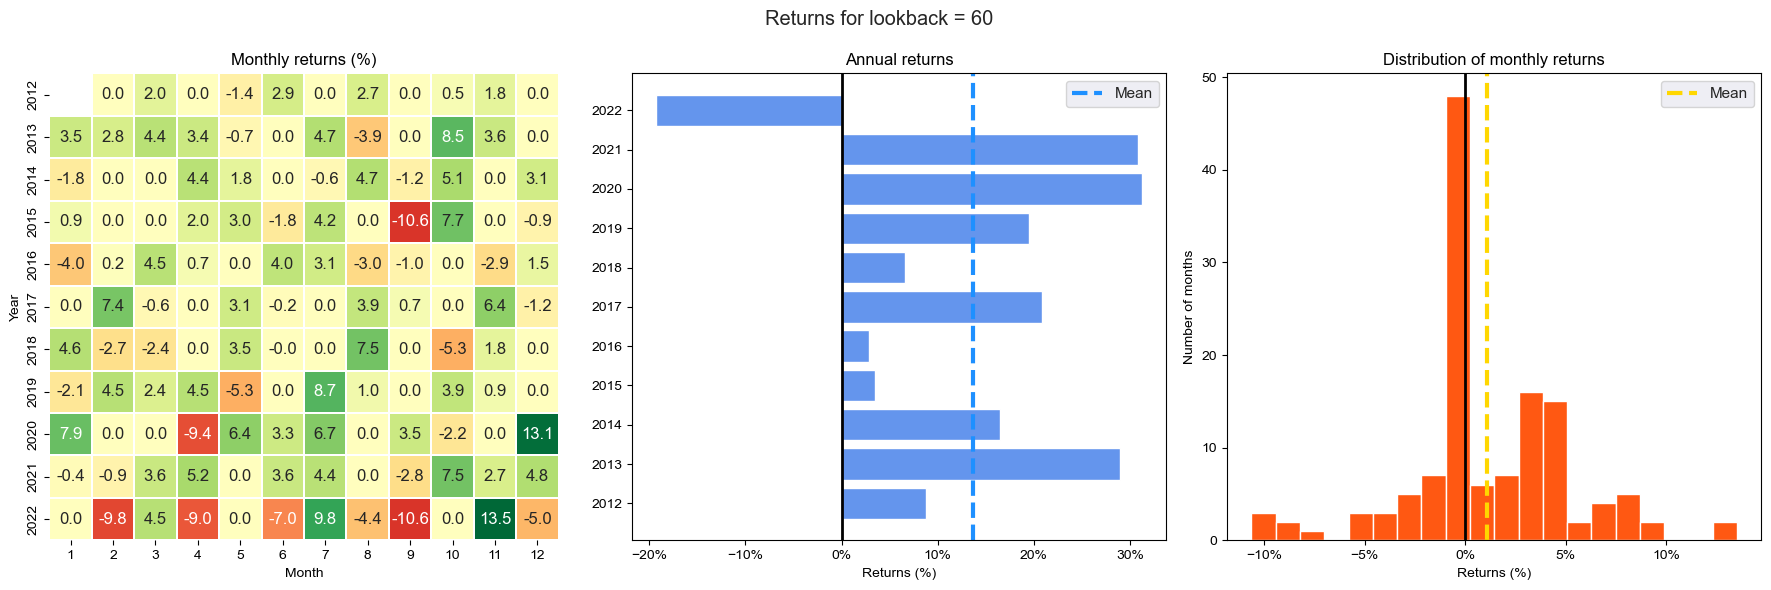

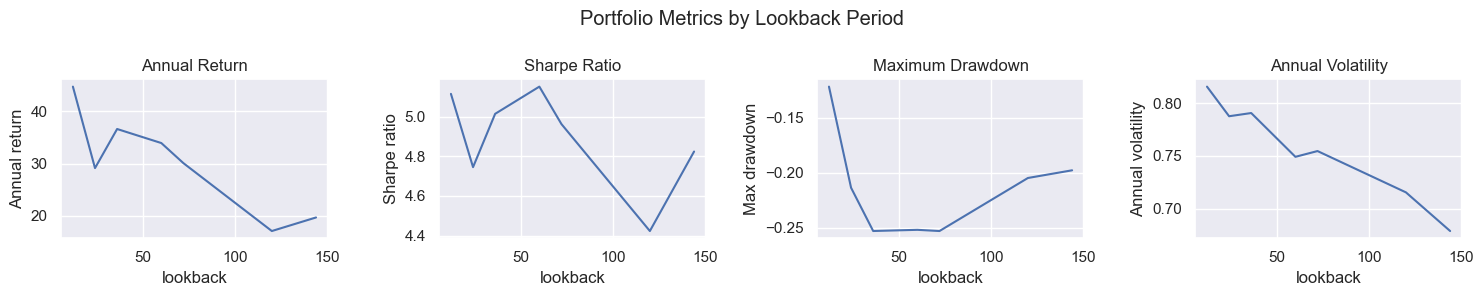


Detailed Metrics by Lookback Period:


lookback,12,24,36,60,72,120,144
Annual return,44.744931,29.132397,36.624009,33.932514,30.079704,17.071622,19.671891
Cumulative returns,3.099639,2.514260,2.814360,2.711293,2.554635,1.909992,2.058003
Annual volatility,0.815770,0.787694,0.790729,0.749205,0.754674,0.715498,0.678830
Sharpe ratio,5.114655,4.745287,5.014027,5.151099,4.962331,4.423326,4.823997
Calmar ratio,367.730686,136.453951,144.897894,134.820787,118.995258,83.427662,99.532458
Stability,0.550731,0.559380,0.558432,0.571688,0.569907,0.582921,0.595653
Max drawdown,-0.121679,-0.213496,-0.252757,-0.251686,-0.252781,-0.204628,-0.197643
Omega ratio,2.469909,2.157822,2.214230,2.239893,2.160979,1.991200,2.148825
Sortino ratio,8.906929,6.960589,7.753688,7.640548,7.509639,7.989588,8.741301
Skew,0.908566,-0.199709,-0.188462,-0.390341,-0.387969,-0.059743,0.056352


In [102]:
# Plot key metrics
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
fig.suptitle("Portfolio Metrics by Lookback Period")

# Annual Return
sns.lineplot(data=metrics_df, x="lookback", y="Annual return", ax=axes[0])
axes[0].set_title("Annual Return")

# Sharpe Ratio
sns.lineplot(data=metrics_df, x="lookback", y="Sharpe ratio", ax=axes[1])
axes[1].set_title("Sharpe Ratio")

# Max Drawdown
sns.lineplot(data=metrics_df, x="lookback", y="Max drawdown", ax=axes[2])
axes[2].set_title("Maximum Drawdown")

# Volatility
sns.lineplot(data=metrics_df, x="lookback", y="Annual volatility", ax=axes[3])
axes[3].set_title("Annual Volatility")

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics by Lookback Period:")
df = metrics_df.set_index("lookback")
df.T